In [86]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from subprocess import check_output

from matplotlib import pyplot
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten
from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping

from keras.preprocessing.image import ImageDataGenerator

print(check_output(["ls", "./dataset/"]).decode("utf8"))

sample_submission.csv
test.json
train.json



In [20]:
#Load data
train = pd.read_json("./dataset/train.json")
test = pd.read_json("./dataset/test.json")
train.inc_angle = train.inc_angle.replace('na', 0)
train.inc_angle = train.inc_angle.astype(float).fillna(0.0)
print("loading files done!")

loading files done!


In [24]:
# Process the data and splitting
x_band1 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_1"]])
x_band2 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_2"]])
X_train = np.concatenate([x_band1[:, :, :, np.newaxis], 
                         x_band2[:, :, :, np.newaxis], 
                        ((x_band1+x_band1)/2)[:, :, :, np.newaxis]], axis=-1)
X_angle_train = np.array(train.inc_angle)
y_train = np.array(train["is_iceberg"])

# Test data
x_band1 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test["band_1"]])
x_band2 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test["band_2"]])
X_test = np.concatenate([x_band1[:, :, :, np.newaxis], 
                        x_band2[:, :, :, np.newaxis], 
                        ((x_band1+x_band1)/2)[:, :, :, np.newaxis]], axis=-1)
X_angle_test = np.array(test.inc_angle)

X_train, X_valid, X_angle_train, X_angle_valid, y_train, y_valid = train_test_split(X_train
                    , X_angle_train, y_train, random_state=123, train_size=0.75)

print("X_train: ", X_train.shape)
print("X_angle_train: ", X_angle_train.shape)
print("y_train: ", y_train.shape)

print("***************")

print("X_valid: ", X_valid.shape)
print("X_angle_valid: ", X_angle_valid.shape)
print("y_valid: ", y_valid.shape)

print("***************")

print("X_test: ", X_test.shape)
print("X_angle_test: ", X_angle_test.shape)

X_train:  (1203, 75, 75, 3)
X_angle_train:  (1203,)
y_train:  (1203,)
***************
X_valid:  (401, 75, 75, 3)
X_angle_valid:  (401,)
y_valid:  (401,)
***************
X_test:  (8424, 75, 75, 3)
X_angle_test:  (8424,)


In [58]:
%matplotlib inline
import cv2

for i in range(X_train.shape[0]):
    X_train[i] = cv2.cvtColor(X_train[i], cv2.COLOR_HLS2RGB)

for i in range(X_valid.shape[0]):
    X_valid[i] = cv2.cvtColor(X_valid[i], cv2.COLOR_HLS2RGB)

for i in range(X_test.shape[0]):
    X_test[i] = cv2.cvtColor(X_test[i], cv2.COLOR_HLS2RGB)

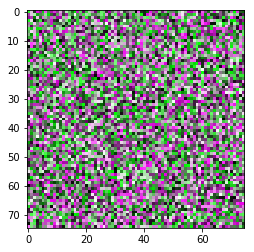

In [89]:
pyplot.imshow(X_test[0])

In [91]:
def get_callbacks(filepath, patience=2):
    es = EarlyStopping('val_loss', patience=patience, mode="min")
    msave = ModelCheckpoint(filepath, save_best_only=True)
    return [es, msave]
    
def get_model():
    bn_model = 0
    p_activation = "elu"
    input_1 = Input(shape=(75, 75, 3), name="X_1")
    input_2 = Input(shape=[1], name="angle")
    
    img_1 = Conv2D(16, kernel_size = (3,3), activation=p_activation) ((BatchNormalization(momentum=bn_model))(input_1))
    img_1 = Conv2D(16, kernel_size = (3,3), activation=p_activation) (img_1)
    img_1 = MaxPooling2D((2,2)) (img_1)
    img_1 = Dropout(0.2)(img_1)
    img_1 = Conv2D(32, kernel_size = (3,3), activation=p_activation) (img_1)
    img_1 = Conv2D(32, kernel_size = (3,3), activation=p_activation) (img_1)
    img_1 = MaxPooling2D((2,2)) (img_1)
    img_1 = Dropout(0.2)(img_1)
    img_1 = Conv2D(64, kernel_size = (3,3), activation=p_activation) (img_1)
    img_1 = Conv2D(64, kernel_size = (3,3), activation=p_activation) (img_1)
    img_1 = MaxPooling2D((2,2)) (img_1)
    img_1 = Dropout(0.2)(img_1)
    img_1 = Conv2D(128, kernel_size = (3,3), activation=p_activation) (img_1)
    img_1 = MaxPooling2D((2,2)) (img_1)
    img_1 = Dropout(0.2)(img_1)
    img_1 = GlobalMaxPooling2D() (img_1)
    
    
    img_2 = Conv2D(128, kernel_size = (3,3), activation=p_activation) ((BatchNormalization(momentum=bn_model))(input_1))
    img_2 = MaxPooling2D((2,2)) (img_2)
    img_2 = Dropout(0.2)(img_2)
    img_2 = GlobalMaxPooling2D() (img_2)
    
    img_concat =  (Concatenate()([img_1, img_2, BatchNormalization(momentum=bn_model)(input_2)]))
    
    dense_ayer = Dropout(0.5) (BatchNormalization(momentum=bn_model) ( Dense(256, activation=p_activation)(img_concat) ))
    dense_ayer = Dropout(0.5) (BatchNormalization(momentum=bn_model) ( Dense(64, activation=p_activation)(dense_ayer) ))
    output = Dense(1, activation="sigmoid")(dense_ayer)
    
    model = Model([input_1,input_2],  output)
    optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    return model

In [92]:
model = get_model()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X_1 (InputLayer)                (None, 75, 75, 3)    0                                            
__________________________________________________________________________________________________
batch_normalization_36 (BatchNo (None, 75, 75, 3)    12          X_1[0][0]                        
__________________________________________________________________________________________________
conv2d_57 (Conv2D)              (None, 73, 73, 16)   448         batch_normalization_36[0][0]     
__________________________________________________________________________________________________
conv2d_58 (Conv2D)              (None, 71, 71, 16)   2320        conv2d_57[0][0]                  
__________________________________________________________________________________________________
max_poolin

In [ ]:
gen = ImageDataGenerator(horizontal_flip = True,
                         vertical_flip = True,
                         width_shift_range = 0.1,
                         height_shift_range = 0.1,
                         zoom_range = 0.1,
                         rotation_range = 40)

def gen_flow_for_two_inputs(X1, X2, y):
    genX1 = gen.flow(X1,y,  batch_size=batch_size,seed=666)
    genX2 = gen.flow(X1,X2, batch_size=batch_size,seed=666)
    while True:
            X1i = genX1.next()
            X2i = genX2.next()
            #Assert arrays are equal - this was for peace of mind, but slows down training
            #np.testing.assert_array_equal(X1i[0],X2i[0])
            yield [X1i[0], X2i[1]], X1i[1]
            
gen_flow = gen_flow_for_two_inputs(X_train, X_angle_train, y_train)

In [93]:
file_path = "model_weights.hdf5"
callbacks = get_callbacks(filepath=file_path, patience=5)

model.fit_generator(gen_flow
                    ,validation_data=([X_valid, X_angle_valid], y_valid)
                     ,steps_per_epoch=len(X_train)/32
                    ,epochs = 25
                     ,callbacks=callbacks)

Epoch 1/25
38/37 [==============================] - 147s 4s/step - loss: 0.7868 - acc: 0.6323 - val_loss: 0.6277 - val_acc: 0.6185
Epoch 2/25
38/37 [==============================] - 147s 4s/step - loss: 0.5469 - acc: 0.7527 - val_loss: 0.4740 - val_acc: 0.7930
Epoch 3/25
38/37 [==============================] - 130s 3s/step - loss: 0.4625 - acc: 0.8023 - val_loss: 0.3520 - val_acc: 0.8504
Epoch 4/25
38/37 [==============================] - 146s 4s/step - loss: 0.4319 - acc: 0.8229 - val_loss: 0.3336 - val_acc: 0.8579
Epoch 5/25
38/37 [==============================] - 127s 3s/step - loss: 0.4382 - acc: 0.8150 - val_loss: 0.4778 - val_acc: 0.7930
Epoch 6/25
38/37 [==============================] - 127s 3s/step - loss: 0.3914 - acc: 0.8302 - val_loss: 0.3654 - val_acc: 0.8603
Epoch 7/25
38/37 [==============================] - 126s 3s/step - loss: 0.3859 - acc: 0.8288 - val_loss: 0.3495 - val_acc: 0.8653
Epoch 8/25
38/37 [==============================] - 185s 5s/step - loss: 0.3671 - a

In [94]:
    model.load_weights(filepath=file_path)

    print("Train evaluate:")
    print(model.evaluate([X_train, X_angle_train], y_train, verbose=1, batch_size=200))
    print("####################")
    print("watch list evaluate:")
    print(model.evaluate([X_valid, X_angle_valid], y_valid, verbose=1, batch_size=200))


    prediction = model.predict([X_test, X_angle_test], verbose=1, batch_size=200)

    submission = pd.DataFrame({'id': test["id"], 'is_iceberg': prediction.reshape((prediction.shape[0]))})
    submission.head(10)

    submission.to_csv("./submission.csv", index=False)

Train evaluate:
1203/1203 [==============================] - 24s 20ms/step
[0.25459576168361547, 0.90108062699746805]
####################
watch list evaluate:
401/401 [==============================] - 6s 15ms/step
[0.2783594849958384, 0.88279301032163848]
8424/8424 [==============================] - 166s 20ms/step


In [69]:
import os
print(check_output(["ls", "./submissions"]).decode("utf8"))

sub_200_ens_densenet.csv
sub_TF_keras.csv
sub_blend009.csv
sub_fcn.csv
sub_keras_beginner.csv



In [71]:
sub_path = "./submissions/"
all_files = os.listdir(sub_path)

# Read and concatenate submissions
outs = [pd.read_csv(os.path.join(sub_path, f), index_col=0) for f in all_files]
concat_sub = pd.concat(outs, axis=1)
cols = list(map(lambda x: "is_iceberg_" + str(x), range(len(concat_sub.columns))))
concat_sub.columns = cols
concat_sub.reset_index(inplace=True)
concat_sub.head()

,id,is_iceberg_0,is_iceberg_1,is_iceberg_2,is_iceberg_3,is_iceberg_4,is_iceberg_5
0,5941774d,0.094676,0.005586,0.046490,1.943216e-02,0.008171,0.010215
1,4023181e,0.952222,0.145927,0.062827,3.168809e-02,0.638348,0.237662
2,b20200e4,0.167771,0.000015,0.023744,4.000000e-08,0.008061,1.000000
3,e7f018bb,0.989356,0.999914,0.989423,9.925741e-01,0.999506,0.999533
4,4371c8c3,0.900321,0.033843,0.101041,2.215107e-02,0.774739,0.994269


In [75]:
# get the data fields ready for stacking
concat_sub['is_iceberg_max'] = concat_sub.iloc[:, 1:7].max(axis=1)
concat_sub['is_iceberg_min'] = concat_sub.iloc[:, 1:7].min(axis=1)
concat_sub['is_iceberg_mean'] = concat_sub.iloc[:, 1:7].mean(axis=1)
concat_sub['is_iceberg_median'] = concat_sub.iloc[:, 1:7].median(axis=1)

In [76]:
# set up cutoff threshold for lower and upper bounds, easy to twist 
cutoff_lo = 0.8
cutoff_hi = 0.2

In [77]:
concat_sub.head()

,id,is_iceberg_0,is_iceberg_1,is_iceberg_2,is_iceberg_3,is_iceberg_4,is_iceberg_5,is_iceberg_max,is_iceberg_min,is_iceberg_mean,is_iceberg_median
0,5941774d,0.094676,0.005586,0.046490,1.943216e-02,0.008171,0.010215,0.094676,5.586202e-03,0.030762,0.014823
1,4023181e,0.952222,0.145927,0.062827,3.168809e-02,0.638348,0.237662,0.952222,3.168809e-02,0.344779,0.191794
2,b20200e4,0.167771,0.000015,0.023744,4.000000e-08,0.008061,1.000000,1.000000,4.000000e-08,0.199932,0.015902
3,e7f018bb,0.989356,0.999914,0.989423,9.925741e-01,0.999506,0.999533,0.999914,9.893560e-01,0.995051,0.996040
4,4371c8c3,0.900321,0.033843,0.101041,2.215107e-02,0.774739,0.994269,0.994269,2.215107e-02,0.471061,0.437890


In [78]:
# load the model with best base performance
sub_base = pd.read_csv('./submissions/sub_200_ens_densenet.csv')
concat_sub['is_iceberg_base'] = sub_base['is_iceberg']
concat_sub['is_iceberg'] = np.where(np.all(concat_sub.iloc[:,1:7] > cutoff_lo, axis=1), 
                                    concat_sub['is_iceberg_max'], 
                                    np.where(np.all(concat_sub.iloc[:,1:7] < cutoff_hi, axis=1),
                                             concat_sub['is_iceberg_min'], 
                                             concat_sub['is_iceberg_base']))
concat_sub[['id', 'is_iceberg']].to_csv('stack_minmax_bestbase.csv', 
                                        index=False, float_format='%.6f')